<a href="https://colab.research.google.com/github/poo5zan/realized-volatility/blob/dev/Univariate_RV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
RUN_FROM_COLAB = True
if RUN_FROM_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

    ROOT_DIR = '/content/drive/My Drive/Research Project/data/'

Mounted at /content/drive


In [ ]:
!pip install darts
!pip install arch

In [14]:
# realized volatility data
import pandas as pd
import os
import numpy as np
from scipy.stats import norm
import scipy.optimize as opt
import datetime
import time
from arch import arch_model
import matplotlib.pyplot as plt
from numba import jit
from sklearn.metrics import mean_squared_error as mse
import warnings
warnings.filterwarnings('ignore')

In [4]:
if RUN_FROM_COLAB:
    DATA_DIR = '/content/drive/My Drive/Research Project/datasets/'
else:
    DATA_DIR = '/Users/pujanmaharjan/uni adelaide/uofa_research_project/datasets'

def get_all_train_data():
    train = pd.read_csv(os.path.join(DATA_DIR, 'optiver-realized-volatility-prediction', 'train_time_id_ordered.csv'))
    return train

def get_unique_col_elements(df: pd.DataFrame, col_name: str):
    return list(df[col_name].unique())

In [5]:
df = get_all_train_data()
print('Total data ', df.shape)
df.head()

Total data  (428932, 4)


,stock_id,time_id,target,time_id_order
0,8,4294,0.005047,0
1,47,4294,0.001244,0
2,105,4294,0.002353,0
3,69,4294,0.001616,0
4,111,4294,0.001917,0


In [132]:
TIME_ID_ORDER_COL = 'time_id_order'
def split_by_time_id_order(data, split_size):
    if split_size < 0 and split_size >= 1:
        raise Exception("invalid split size. valid range (0,1)")
    # time_id_order ranges from 0 to 3829
    min_time_id_order = data[TIME_ID_ORDER_COL].min()
    max_time_id_order = data[TIME_ID_ORDER_COL].max()
    time_id_order_ix = int((max_time_id_order - min_time_id_order) * split_size)
    time_id_order_to_split = min_time_id_order + time_id_order_ix
    data_copy = data.copy()

    first_part = data_copy[data_copy[TIME_ID_ORDER_COL] <= time_id_order_to_split]
    second_part = data_copy[data_copy[TIME_ID_ORDER_COL] > time_id_order_to_split]
    return first_part, second_part

def split_into_train_val_test(data, train_size, val_size):
    train_df, val_test_df = split_by_time_id_order(data, train_size)
    val_df, test_df = split_by_time_id_order(val_test_df, val_size)

    return train_df, val_df, test_df

In [133]:
stock_0 = df[df['stock_id'] == 0].reset_index(drop=True)
stock_0

,stock_id,time_id,target,time_id_order
0,0,4294,0.003267,0
1,0,24033,0.002580,1
2,0,5666,0.002051,2
3,0,29740,0.002364,3
4,0,22178,0.001439,4
...,...,...,...,...
3825,0,24913,0.002402,3825
3826,0,32195,0.002311,3826
3827,0,15365,0.002017,3827
3828,0,10890,0.003475,3828


In [134]:
train, val, test = split_into_train_val_test(stock_0, 0.8, 0.5)

In [135]:
target_df = stock_0['target'].to_frame()
print('target_df ', target_df.shape)
train_target_df = train['target'].to_frame()
print('train_target ', train_target_df.shape)
val_target_df = val['target'].to_frame()
print('val_target ', val_target_df.shape)
test_target_df = val['target'].to_frame()
print('test_target ', test_target_df.shape)


target_df  (3830, 1)
train_target  (3064, 1)
val_target  (383, 1)
test_target  (383, 1)


In [139]:
test_target_df.head()

,target
3064,0.001817
3065,0.002067
3066,0.002109
3067,0.002352
3068,0.001081


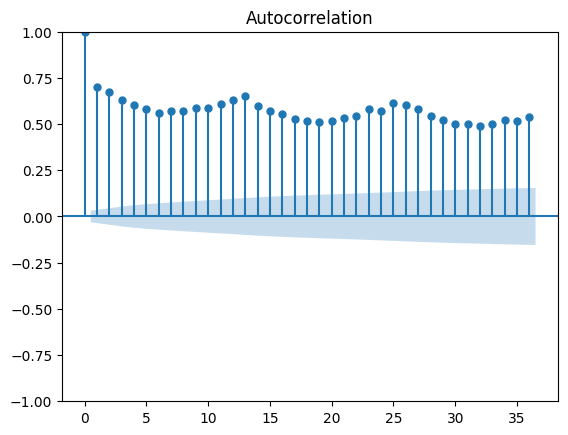

In [30]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plot_acf(target_df)
plt.show()

In [140]:
train_target_df

,target
0,0.003267
1,0.002580
2,0.002051
3,0.002364
4,0.001439
...,...
3059,0.004150
3060,0.001968
3061,0.001796
3062,0.002619


In [141]:
from arch import arch_model
from sklearn.metrics import mean_squared_error

def get_error_from_arch_garch(vol, p, q):
    if vol == 'ARCH':
        arch_model_new = arch_model(train_target_df, mean='Zero', vol=vol, p = p).fit(disp='off')
    else:
        arch_model_new = arch_model(train_target_df, mean='Zero', vol=vol, p = p, q = q).fit(disp='off')

    if vol == 'EGARCH':
        predictions_arch = arch_model_new.forecast(start=0)
        predictions_arch = predictions_arch.variance[-len(test_target_df):]
    else:
        predictions_arch = arch_model_new.forecast(horizon=len(test_target_df))
        predictions_arch = predictions_arch.variance[-1:].transpose().to_numpy()
    arch_rmse = mean_squared_error(test_target_df.to_numpy(), np.sqrt(predictions_arch), squared=False)
    print('RMSE for ', vol, ' is ', arch_rmse)
    print('BIC ', arch_model_new.bic)
    print('AIC ', arch_model_new.aic)
    return arch_rmse, arch_model_new.bic, arch_model_new.aic


In [142]:
# run for multiple values of p and find one with least value of BIC
get_error_from_arch_garch('ARCH', 1, 0)

RMSE for  ARCH  is  0.00180603137829884
BIC  -24773.781978175342
AIC  -24785.836931237063


(0.00180603137829884, -24773.781978175342, -24785.836931237063)

In [143]:
# run for multiple values of p,q and find the pair with least value of BIC
get_error_from_arch_garch('GARCH', 1, 1)

RMSE for  GARCH  is  0.0026064163513010745
BIC  -24986.392372910876
AIC  -25004.474802503457


(0.0026064163513010745, -24986.392372910876, -25004.474802503457)

In [144]:
# run for multiple values of p,q and find the pair with least value of BIC
get_error_from_arch_garch('EGARCH', 1, 1)
# eg = arch_model(train_target_df, mean='Zero', vol='EGARCH', p = 1, q = 1).fit(disp='off')

RMSE for  EGARCH  is  6.537841036508572
BIC  1290193.0491530718
AIC  1290174.9667234793


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


(6.537841036508572, 1290193.0491530718, 1290174.9667234793)

In [112]:
len(train_target_df)

3064

In [147]:
def make_rv_lags(df_rv_lag, number_of_periods: int):
    # add past rv
    for i in range(1, number_of_periods + 1):
        df_rv_lag[f'lag_{i}_rv'] = df_rv_lag['target'].shift(periods=i)

    df_rv_lag = df_rv_lag.dropna()
    return df_rv_lag

In [148]:
train_target_df

,target
0,0.003267
1,0.002580
2,0.002051
3,0.002364
4,0.001439
...,...
3059,0.004150
3060,0.001968
3061,0.001796
3062,0.002619
